In [17]:
import torch
import torch.nn as nn
from torchsummary import summary

import numpy as np
from typing import Any
from torchvision import datasets, transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        skip = x  # store the output for the skip connection
        x = self.maxpool(x)
        return x, skip


class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.upsample = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        #print("x: ", x.shape)
        #print("skip: ", skip.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.upsample(x)

        # concatenate the skip connection
        x = torch.cat((x, skip), dim=1)

        return x

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.contract1 = ContractingBlock(in_channels, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)
        self.bottle_neck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        self.upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.expand1 = ExpandingBlock(1024, 512)
        self.expand2 = ExpandingBlock(512, 256)
        self.expand3 = ExpandingBlock(256, 128)

        self.final_dim_reduction = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True)])
                                          #nn.Conv2d(64,2, kernel_size=3, padding=1),
                                          #nn.ReLU(inplace=True)])
        self.final_block = nn.Conv2d(64, out_channels, kernel_size=1)



    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        #print("first contract block:", x.shape, skip1.shape)
        x, skip2 = self.contract2(x)
        #print("second contract block:", x.shape, skip2.shape)
        x, skip3 = self.contract3(x)
        #print("third contract block:", x.shape, skip3.shape)
        x, skip4 = self.contract4(x)
        #print("fourth contract block:", x.shape, skip4.shape)
        x = self.bottle_neck(x)
        #print("bottle neck:", x.shape)
        x = self.upsample(x)
        #print("upsample:", x.shape)
        x = torch.cat((x, skip4), dim=1)
        #print("cat:", x.shape)

        # Expanding path
        #print("-------------")
        #print("starting expand block:", x.shape)
        x3 = self.expand1(x, skip3)
        #print("after first expand block:", x3.shape)
        x2 = self.expand2(x3, skip2)
        #print("after second expand block:", x2.shape)
        x1 = self.expand3(x2, skip1)
        #print("after third expand block:", x1.shape)
        #x1 = self.expand4(x2, skip1)

        x  = self.final_dim_reduction(x1)
        #print("after final dim reduction:", x.shape)
        x_out = self.final_block(x)
        #print("after 1 x 1:", x_out.shape)
        #return F.log_softmax(x_out, dim=1)
        return x_out

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
unet_model = UNet(in_channels=3, out_channels=3).to(device)

In [6]:
summary(unet_model, input_size=(3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
         MaxPool2d-7           [-1, 64, 24, 24]               0
  ContractingBlock-8  [[-1, 64, 24, 24], [-1, 64, 48, 48]]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
      BatchNorm2d-10          [-1, 128, 24, 24]             256
             ReLU-11          [-1, 128, 24, 24]               0
           Conv2d-12          [-1, 128, 24, 24]         147,584
      BatchNorm2d-13          [-1, 128, 24, 24]             256
             ReLU-14        

C:\Users\rohit\anaconda3\envs\tf\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


In [57]:
def oxford_transforms(image, mask):
    # Resize
    resize = transforms.Resize(size=(48, 48))
    image = resize(image)
    mask = resize(mask)

    # Transform to tensor
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    mask_channels = []
    mask = np.asarray(mask)-1
    for class_id in range(0,3):
        mask_channels.append(mask == class_id)
    #mask_tensor = torch.tensor(mask, dtype=torch.long)
    #return image,mask_tensor
    return image, torch.tensor(mask_channels, dtype=float)

class OxfordPetDataset(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)


In [58]:
def load_oxford_pet_data(train_transforms, test_transforms, batch_size, **kwargs):
    train_data = datasets.OxfordIIITPet('./', split='trainval', transforms = train_transforms, target_transform = None, target_types='segmentation', download=True)
    test_data = datasets.OxfordIIITPet('./', split='test', transforms = test_transforms, target_transform = None, target_types='segmentation', download=True)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              **kwargs)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)
    return train_loader, test_loader

In [59]:
torch.manual_seed(1)
batch_size = 32

In [60]:
train_loader, test_loader = load_oxford_pet_data(train_transforms=oxford_transforms,
                                                test_transforms=oxford_transforms,
                                                batch_size=batch_size)

In [61]:
image, mask = next(iter(train_loader))
image.shape, mask.shape

(torch.Size([32, 3, 48, 48]), torch.Size([32, 3, 48, 48]))

In [62]:
idx = 11

mask_array = np.asarray(mask[idx]).transpose()
image_array = np.asarray(image[idx]).squeeze().transpose()

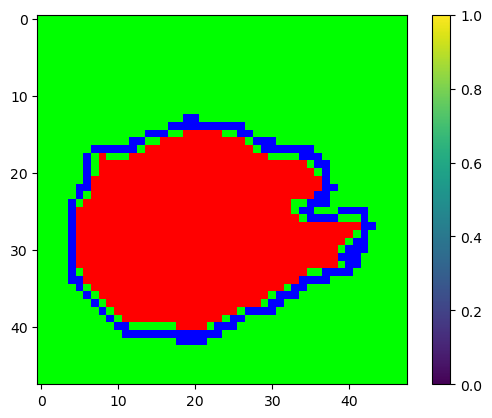

(48, 48, 3)


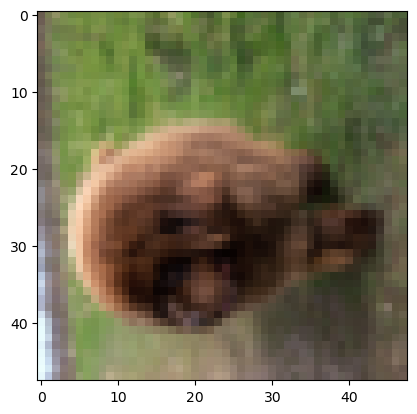

In [63]:
plt.imshow(mask_array.squeeze())
plt.colorbar()
plt.show()
plt.figure()

print(image_array.shape)
plt.imshow(image_array)
plt.show()

In [14]:
from tqdm import tqdm

In [74]:
def model_train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, mask) in enumerate(pbar):
        data, mask = data.to(device), mask.to(device)
        optimizer.zero_grad()
        
        pred_mask = model(data)
        
        loss = criterion(pred_mask, mask)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        processed += len(data)
        pbar.set_description(desc = f'Train Loss: {loss.item()}, batch_idx: {batch_idx}')
    
    train_losses.append(train_loss/len(train_loader))
    return loss.item()

In [75]:
def model_test(model, device, test_loader, criterion, test_acc, test_losses):
    
    model.eval()
    pbar = tqdm(test_loader)
    test_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, masks) in enumerate(pbar):
        data, masks = data.to(device), masks.to(device)
        
        pred_masks = model(data)
        loss = criterion(pred_masks, masks)
        
        test_loss += loss.item()
        processed += len(data)
        pbar.set_description(desc = f"Test Loss: {loss.item()}, batch_idx: {batch_idx}")
    
    test_losses.append(test_loss/len(train_loader))
    return loss.item()

In [76]:
def plot_sample(model, device, test_loader, to_show=5):
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    
    model.eval()
    pred_masks = model(images)
    
    for idx in range(to_show):
        plt.subplot(1, 3, 1)
        plt.imshow(np.array(images[idx].cpu()).transpose())
        plt.title('Image')
        plt.grid('off')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(1, 3, 2)
        ground_truth = np.asarray(masks[idx].cpu())
        ground_truth = np.argmax(ground_truth, axis=0)
        plt.imshow(ground_truth.T)
        plt.title('Ground Truth')
        plt.grid('off')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(1, 3, 3)
        prediction = pred_masks[idx].cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=0)
        plt.imshow(prediction.T)
        plt.title('Predicted Mask')
        plt.grid('off')
        plt.xticks([])
        plt.yticks([])
        
        plt.show()
    

In [77]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

num_epochs = 40
unet_model = UNet(in_channels=3, out_channels=3).to(device)
criterion = F.cross_entropy
optimizer = torch.optim.Adam(unet_model.parameters())

Epoch: 1


Test Loss: 0.6888322798377252, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.70it/s]


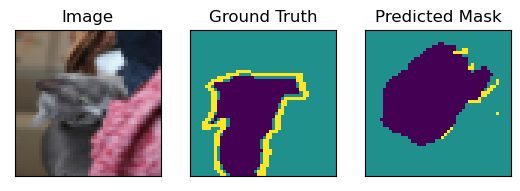

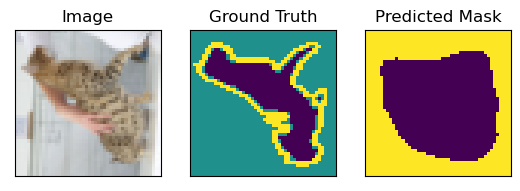

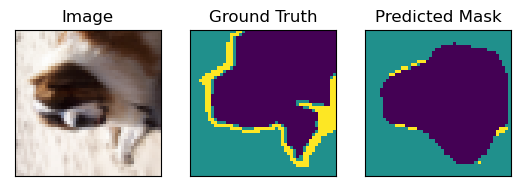

Epoch: 2


Test Loss: 0.5600334611694083, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.75it/s]


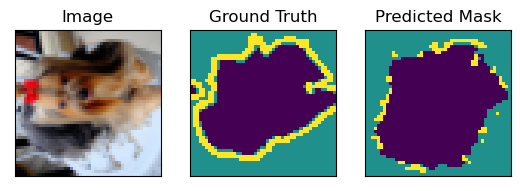

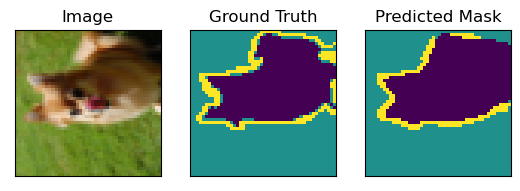

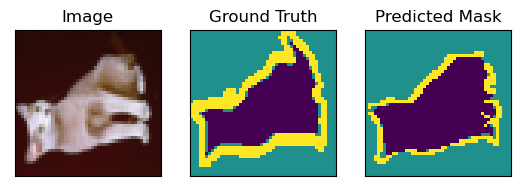

Epoch: 3


Test Loss: 0.47126125060849194, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.76it/s]


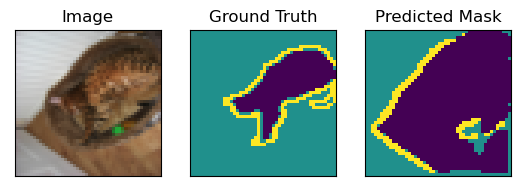

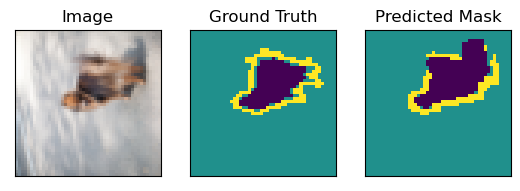

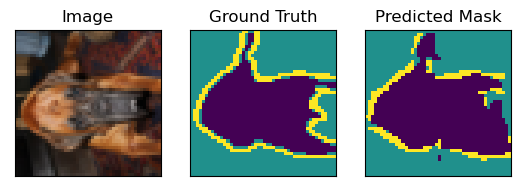

Epoch: 4


Test Loss: 0.38721619828684317, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.68it/s]


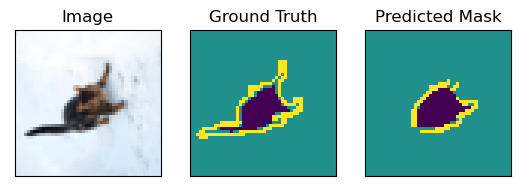

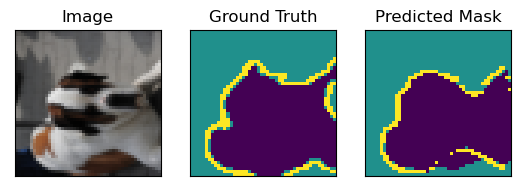

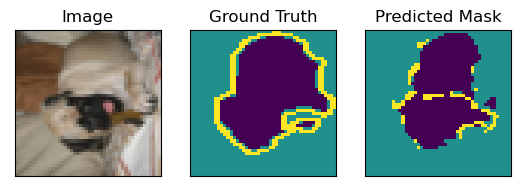

Epoch: 5


Test Loss: 0.4173822612303464, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.61it/s]


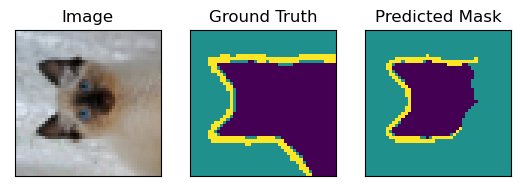

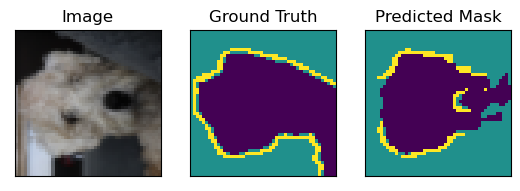

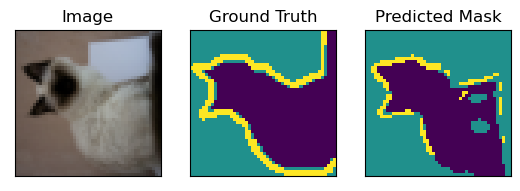

Epoch: 6


Test Loss: 0.48178931981357614, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.79it/s]


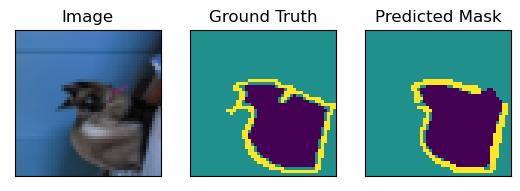

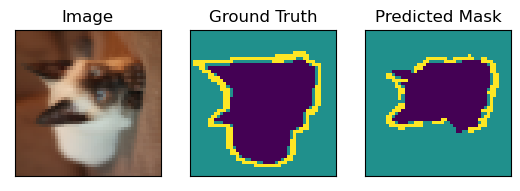

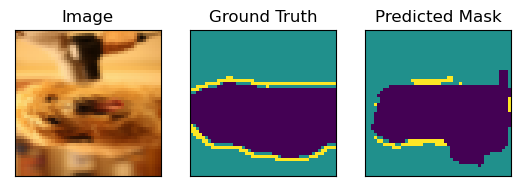

Epoch: 7


Test Loss: 0.4939688669338093, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.66it/s]


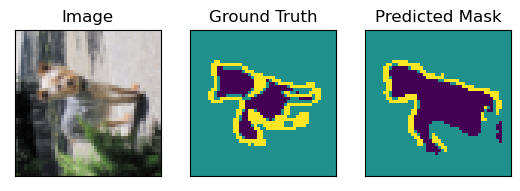

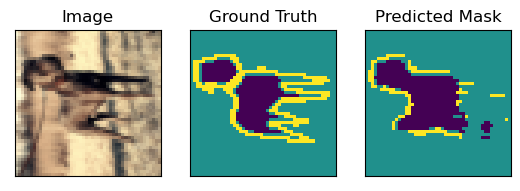

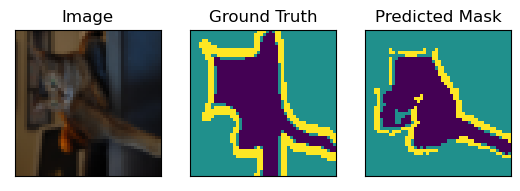

Epoch: 8


Test Loss: 0.4085228854131932, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.72it/s]


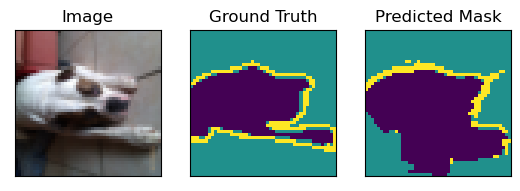

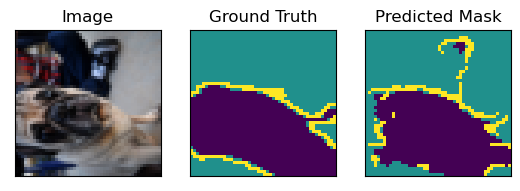

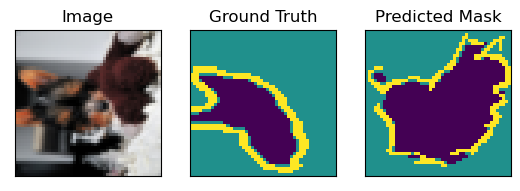

Epoch: 9


Test Loss: 0.37945975402515003, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.79it/s]


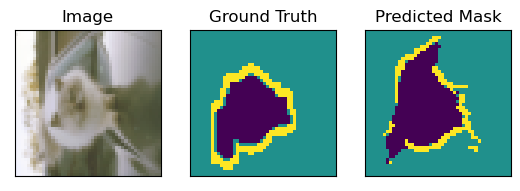

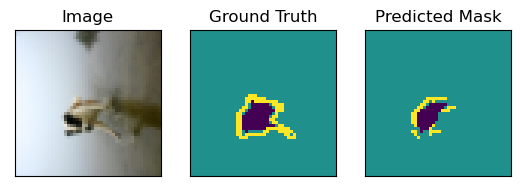

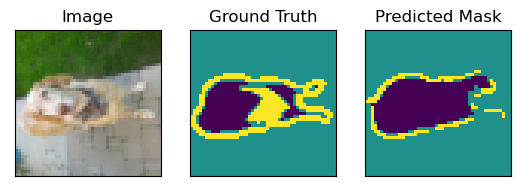

Epoch: 10


Test Loss: 0.3578652277983294, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.74it/s]


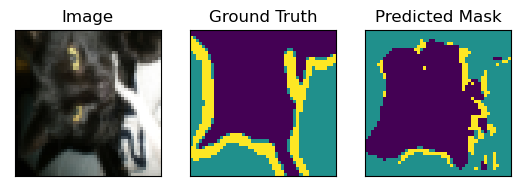

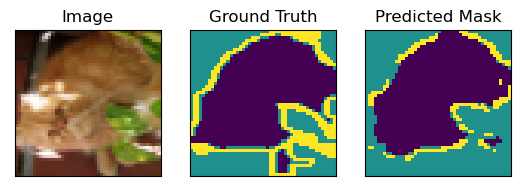

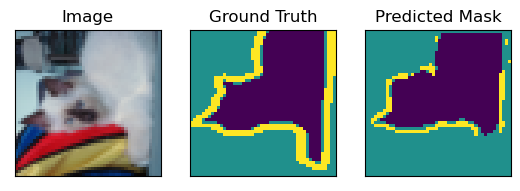

Epoch: 11


Test Loss: 0.4238790663468168, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.69it/s]


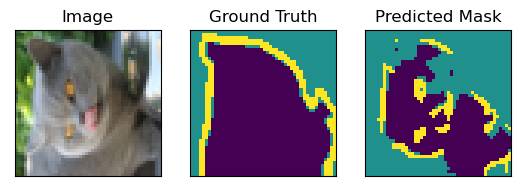

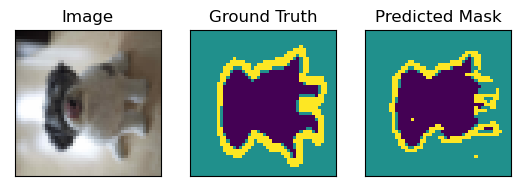

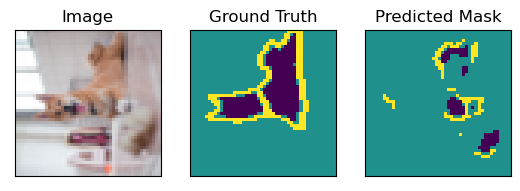

Epoch: 12


Test Loss: 0.338346530391833, batch_idx: 114: 100%|██████████████████████████████████| 115/115 [00:24<00:00,  4.78it/s]


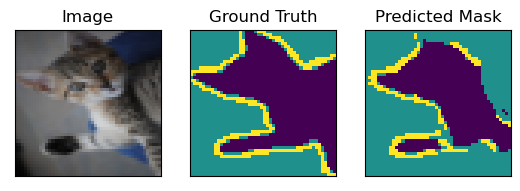

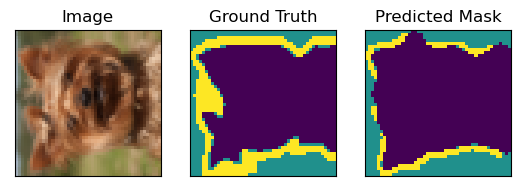

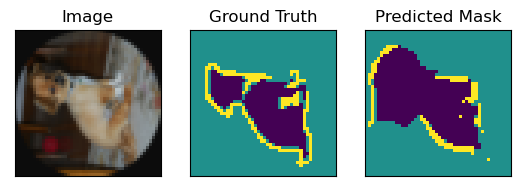

Epoch: 13


Test Loss: 0.26171229724458056, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


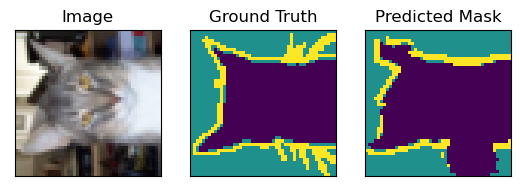

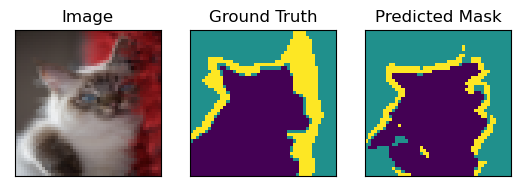

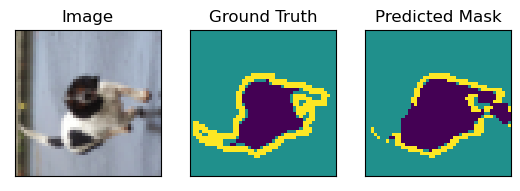

Epoch: 14


Test Loss: 0.2816826354258443, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.77it/s]


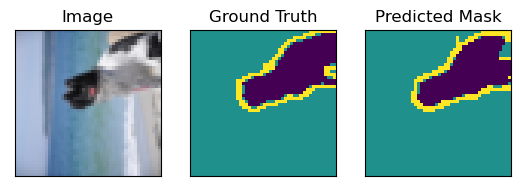

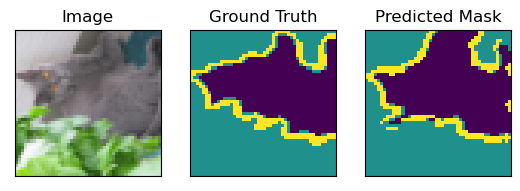

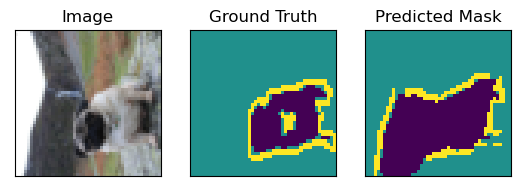

Epoch: 15


Test Loss: 0.45954066267951305, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.70it/s]


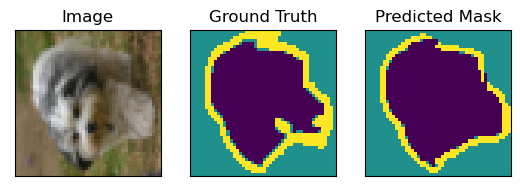

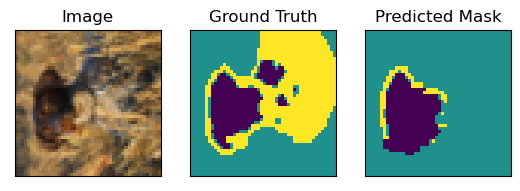

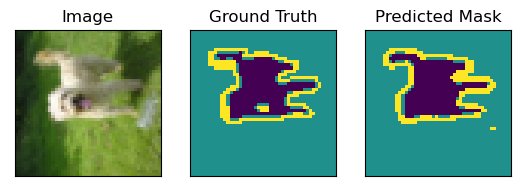

Epoch: 16


Test Loss: 0.33763099340566727, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.76it/s]


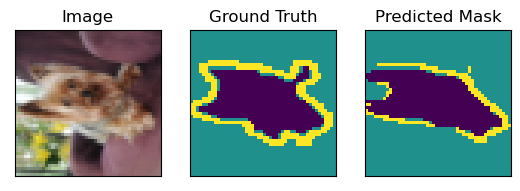

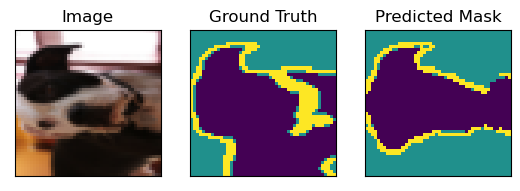

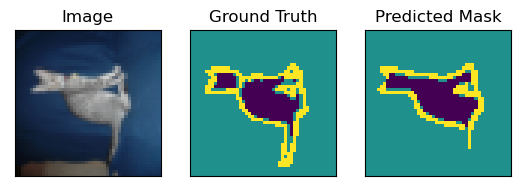

Epoch: 17


Test Loss: 0.40996855732365733, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


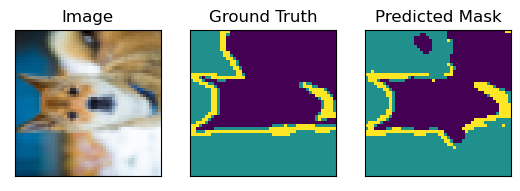

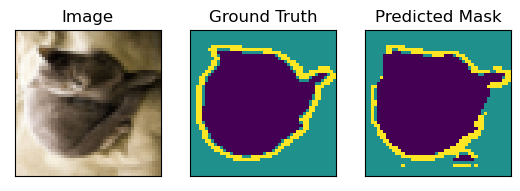

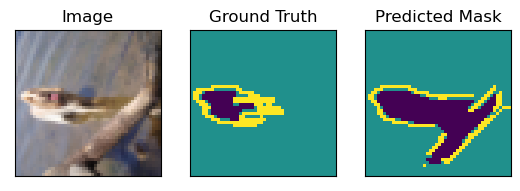

Epoch: 18


Test Loss: 0.3973273604658977, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.70it/s]


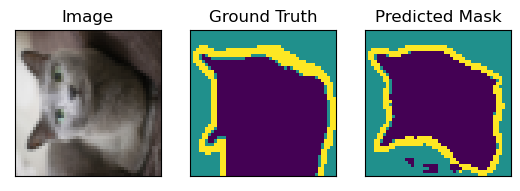

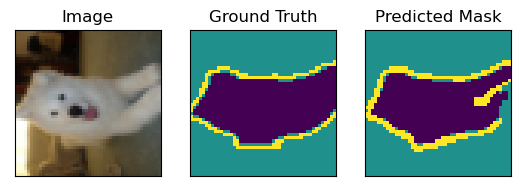

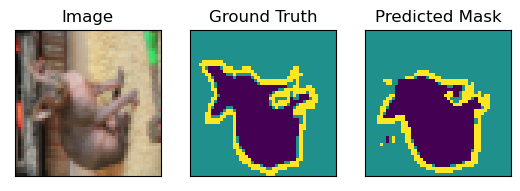

Epoch: 19


Test Loss: 0.3710346729855265, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.78it/s]


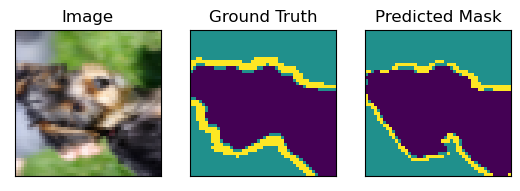

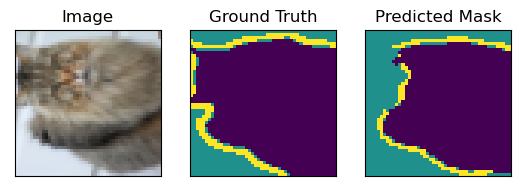

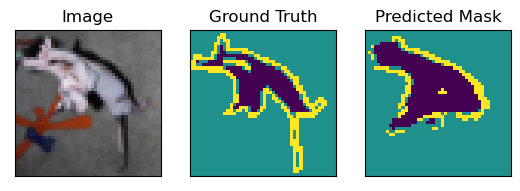

Epoch: 20


Test Loss: 0.42723249873319147, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


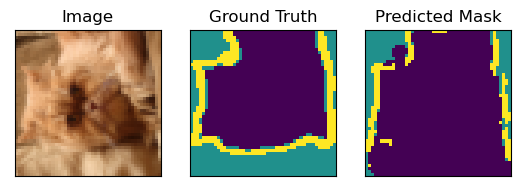

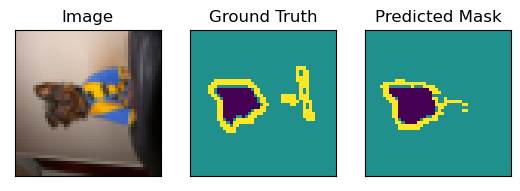

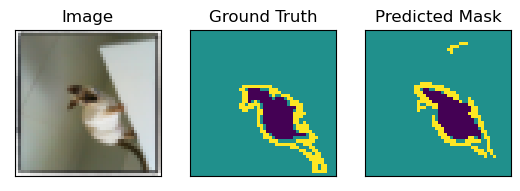

Epoch: 21


Test Loss: 0.3446157329398173, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


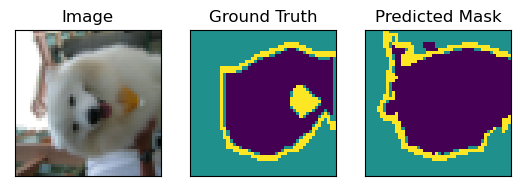

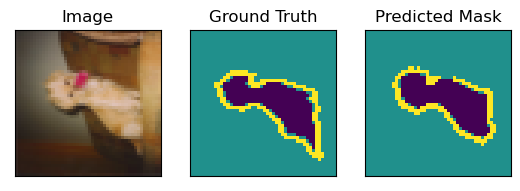

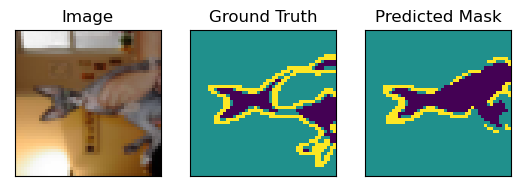

Epoch: 22


Test Loss: 0.4019378257852497, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.67it/s]


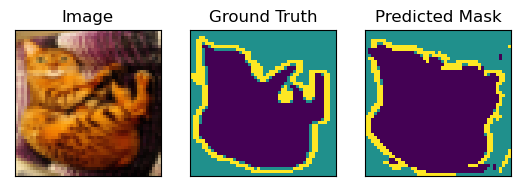

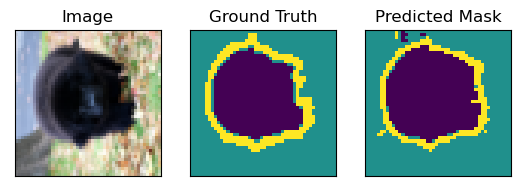

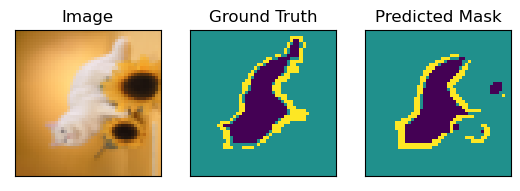

Epoch: 23


Test Loss: 0.36006055179415897, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.70it/s]


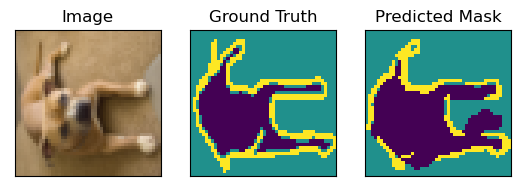

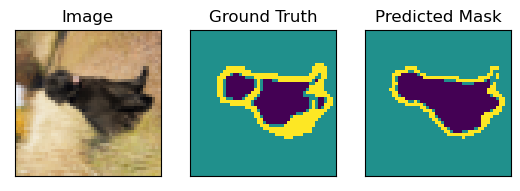

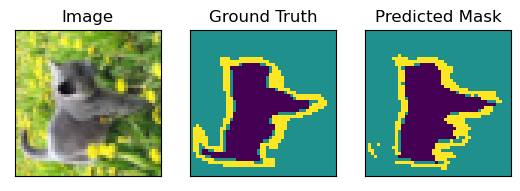

Epoch: 24


Test Loss: 0.32355993283555307, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.77it/s]


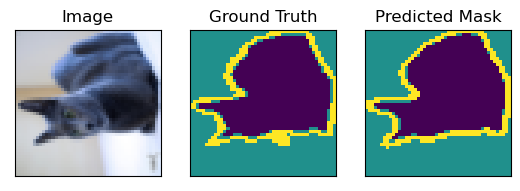

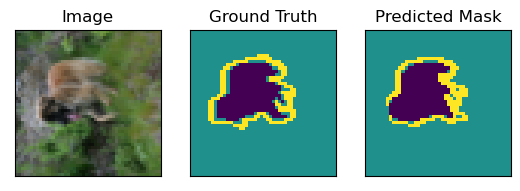

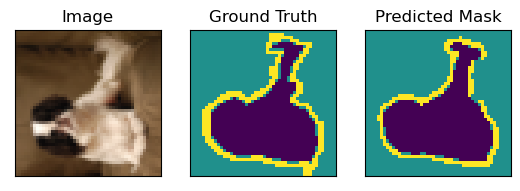

Epoch: 25


Test Loss: 0.3227450759830235, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.61it/s]


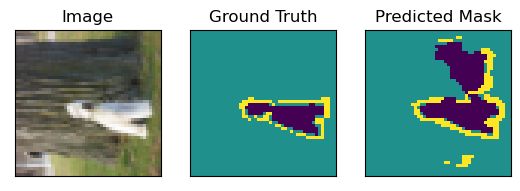

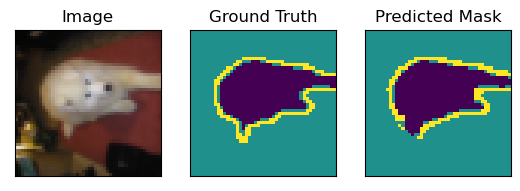

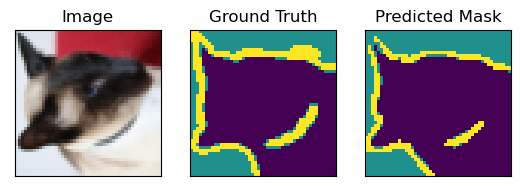

Epoch: 26


Test Loss: 0.3381095574244724, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.74it/s]


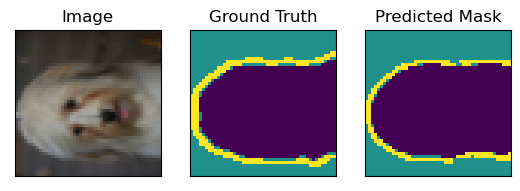

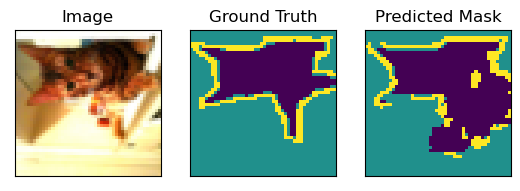

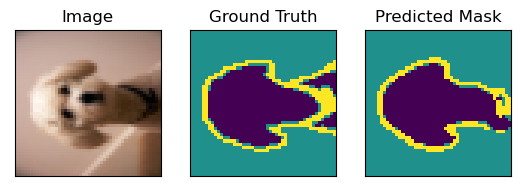

Epoch: 27


Test Loss: 0.29245459852999234, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


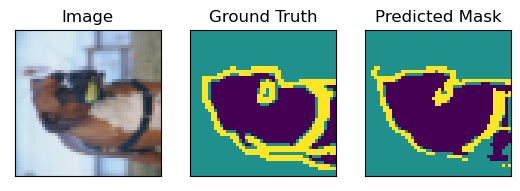

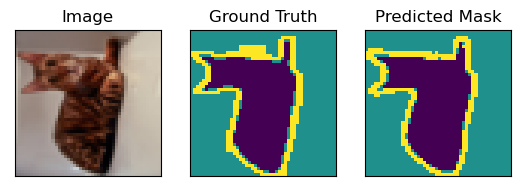

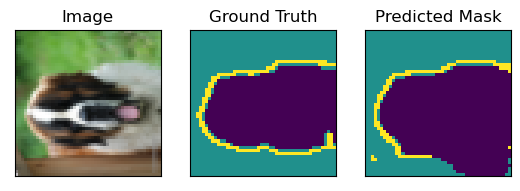

Epoch: 28


Test Loss: 0.3902470075484127, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.70it/s]


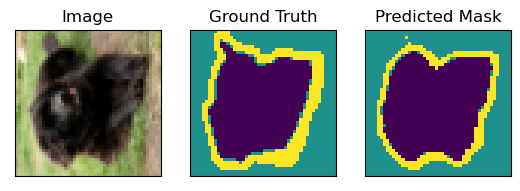

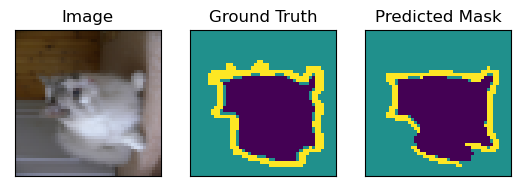

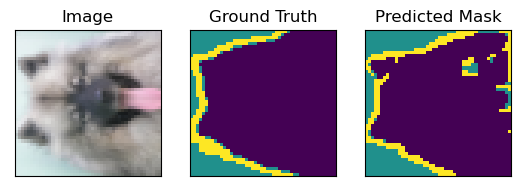

Epoch: 29


Test Loss: 0.40847752291178485, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:23<00:00,  4.81it/s]


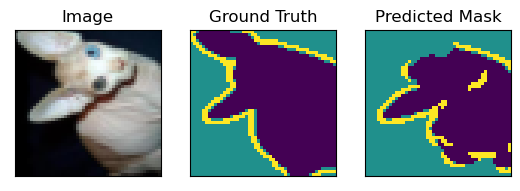

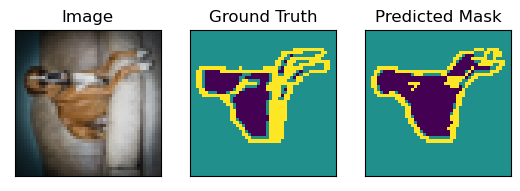

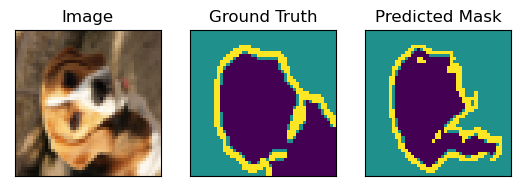

Epoch: 30


Test Loss: 0.30486065331274076, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


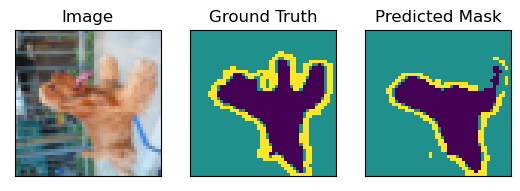

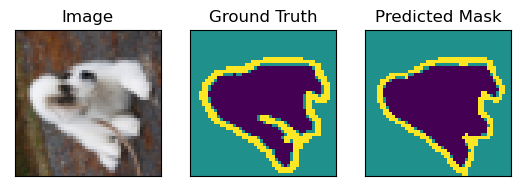

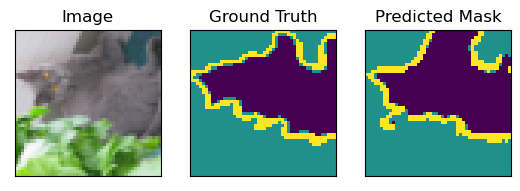

Epoch: 31


Test Loss: 0.32603236468941355, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.78it/s]


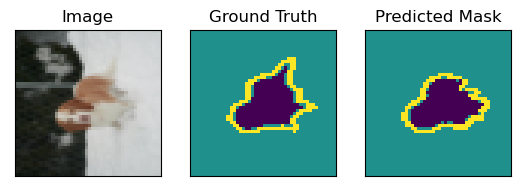

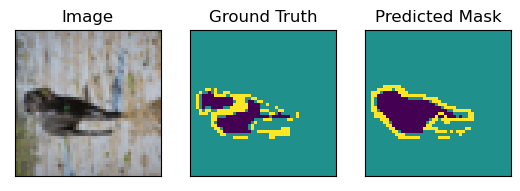

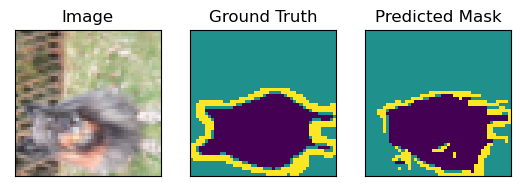

Epoch: 32


Test Loss: 0.36101296960418555, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.75it/s]


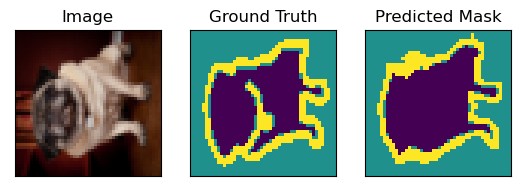

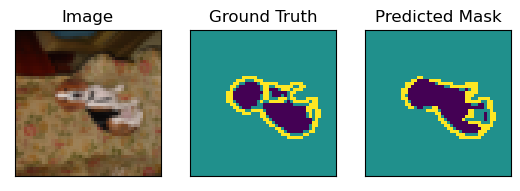

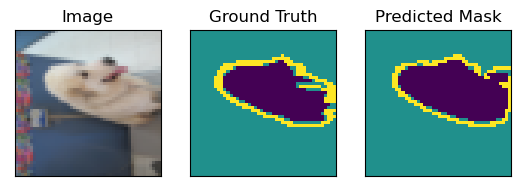

Epoch: 33


Test Loss: 0.35323066891177934, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


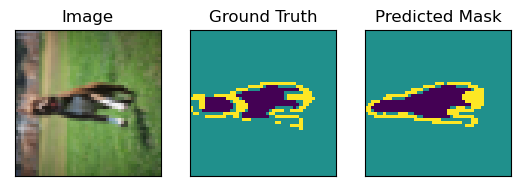

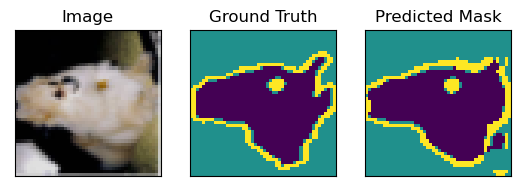

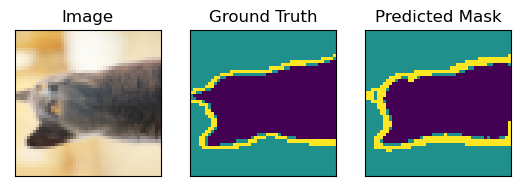

Epoch: 34


Test Loss: 0.4621729698298729, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.69it/s]


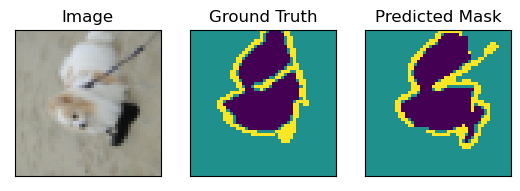

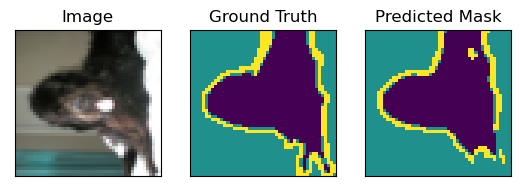

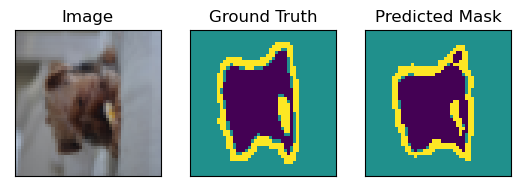

Epoch: 35


Test Loss: 0.46298532282442745, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.72it/s]


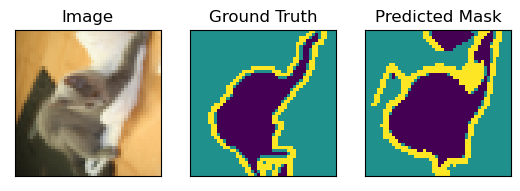

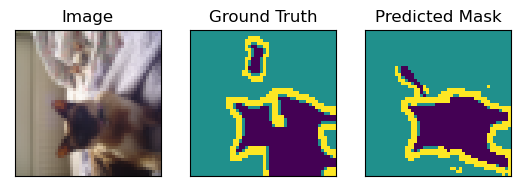

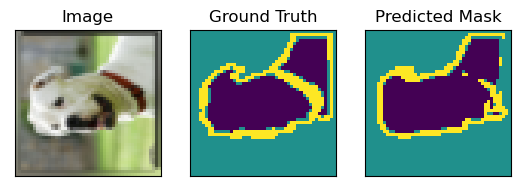

Epoch: 36


Test Loss: 0.46464403086392186, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.69it/s]


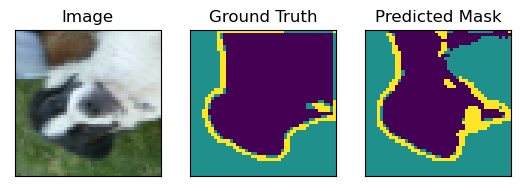

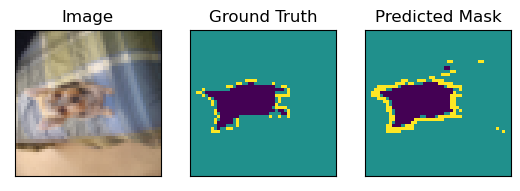

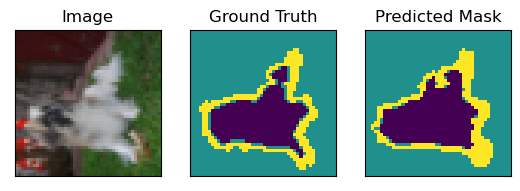

Epoch: 37


Test Loss: 0.3409537392141595, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.74it/s]


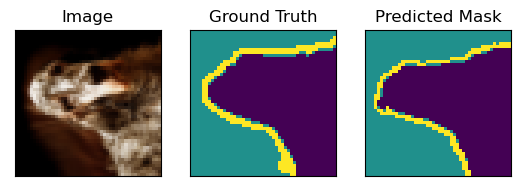

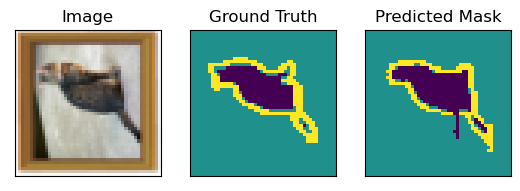

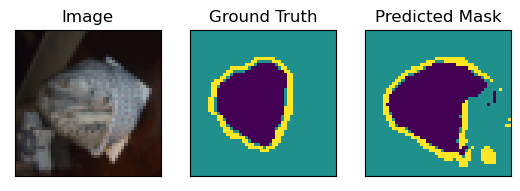

Epoch: 38


Test Loss: 0.42146007035802546, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.75it/s]


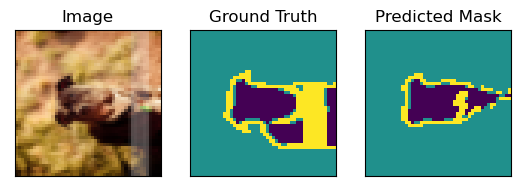

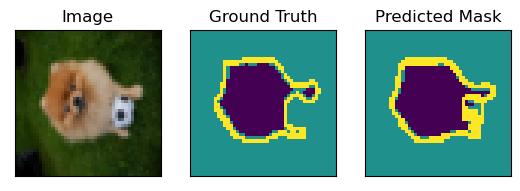

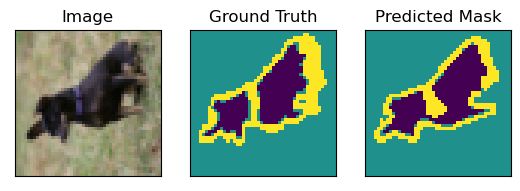

Epoch: 39


Test Loss: 0.40502245328751985, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.79it/s]


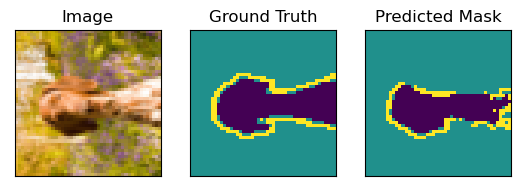

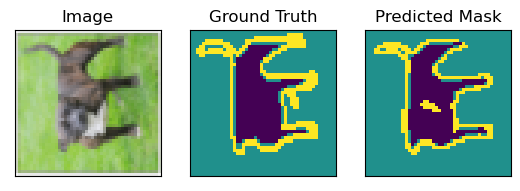

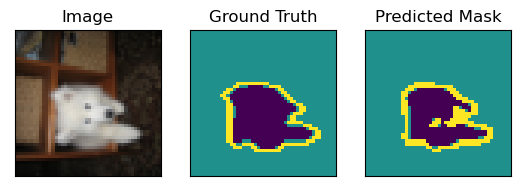

Epoch: 40


Test Loss: 0.42192980315028483, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.70it/s]


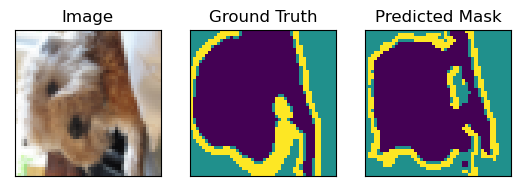

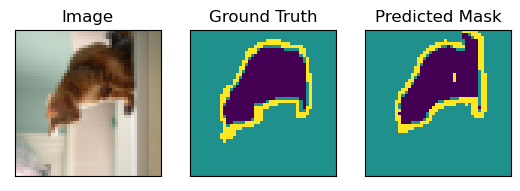

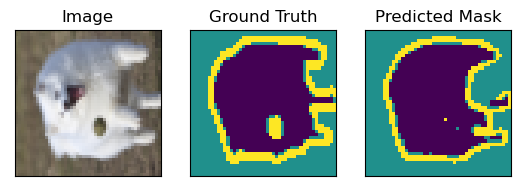

In [78]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    epoch_loss = model_train(unet_model, 
                            device, train_loader,
                            optimizer, criterion, train_acc, train_losses)
    epoch_test_loss = model_test(unet_model, 
                                device, test_loader, criterion, test_acc, test_losses)
    plot_sample(unet_model, device, test_loader, to_show=3)

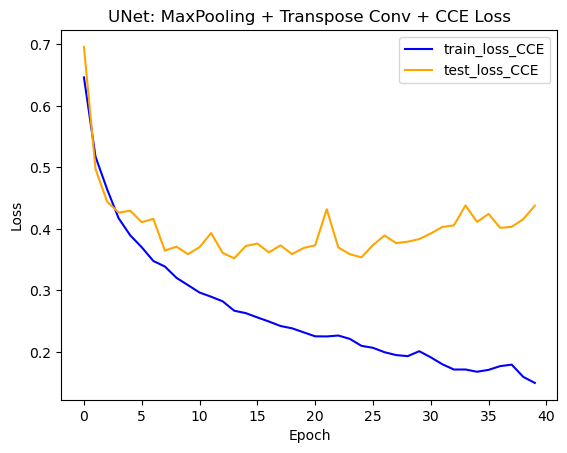

In [82]:
plt.plot(train_losses, label= 'train_loss_CCE', color='blue')
plt.plot(test_losses, label='test_loss_CCE', color='orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("UNet: MaxPooling + Transpose Conv + CCE Loss")
plt.show()

### Dice Loss for Multiclass

In [85]:
images, masks = next(iter(test_loader))
images, masks = image.to(device), masks.to(device)

In [86]:
preds = unet_model(images)

In [94]:
preds.shape

torch.Size([32, 3, 48, 48])

In [99]:
preds_soft = F.softmax(preds, dim=1)

In [100]:
preds_soft.shape

torch.Size([32, 3, 48, 48])

In [101]:
preds_soft.flatten(0, 1).shape

torch.Size([96, 48, 48])

In [102]:
def dice_loss(pred, target):
    smooth = 1e-5
    dice = 0.
    pred = F.softmax(pred, dim=1).flatten(0, 1)
    target = target.flatten(0, 1)
    
    intersection = (pred * target).sum(dim=(-1, -2))
    union = pred.sum(dim=(-1, -2)) + target.sum(dim=(-1, -2))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice.mean()

In [103]:
train_losses_dice = []
test_losses_dice = []
train_acc_dice = []
test_acc_dice = []

num_epochs = 40
unet_model = UNet(in_channels=3, out_channels=3).to(device)
criterion = dice_loss
optimizer = torch.optim.Adam(unet_model.parameters())

Epoch: 1


Test Loss: 0.3569396315123413, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.66it/s]


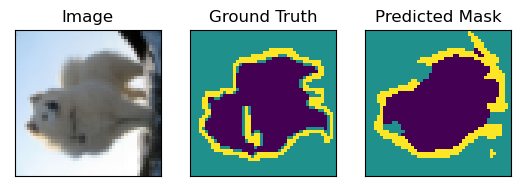

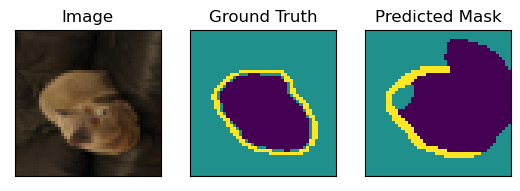

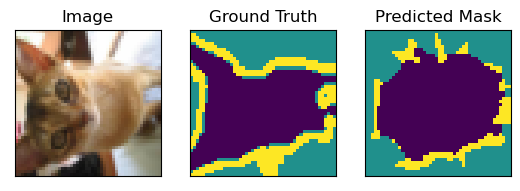

Epoch: 2


Test Loss: 0.302622363766888, batch_idx: 114: 100%|██████████████████████████████████| 115/115 [00:25<00:00,  4.43it/s]


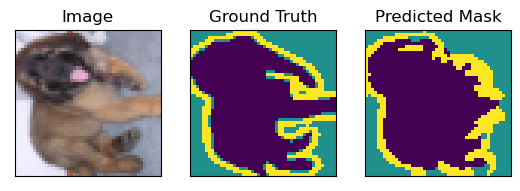

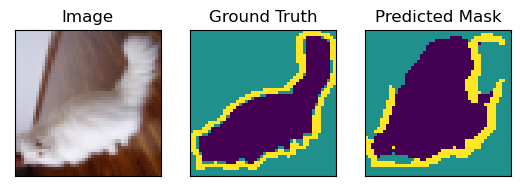

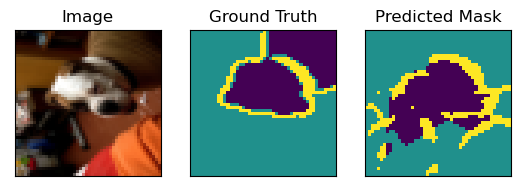

Epoch: 3


Test Loss: 0.2991256059509202, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.76it/s]


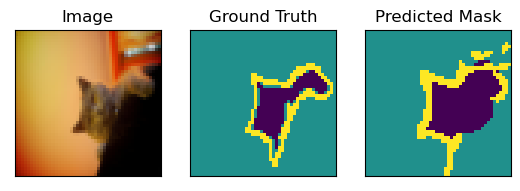

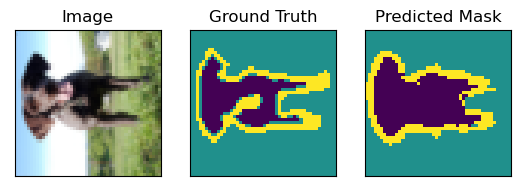

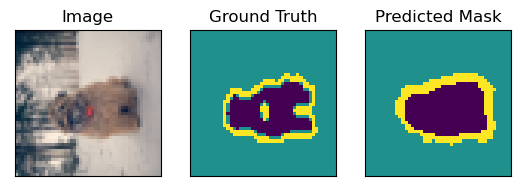

Epoch: 4


Test Loss: 0.2832662456795829, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.78it/s]


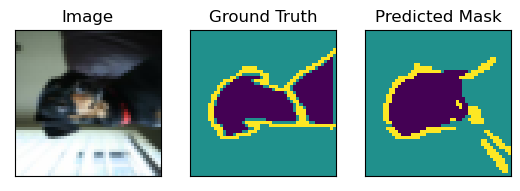

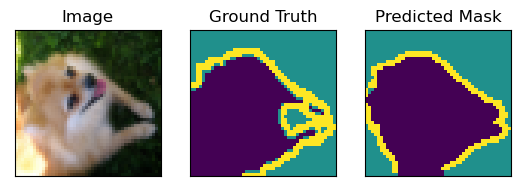

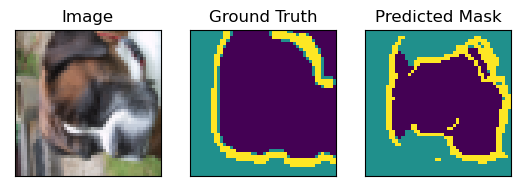

Epoch: 5


Test Loss: 0.24567563774568757, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:23<00:00,  4.87it/s]


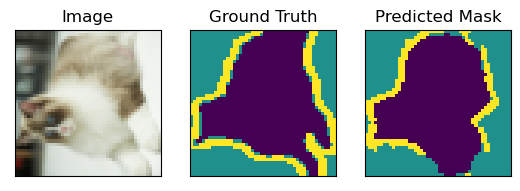

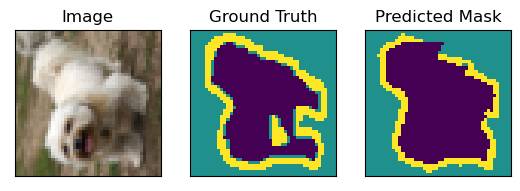

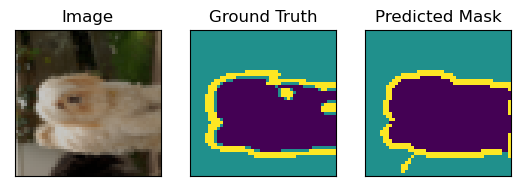

Epoch: 6


Test Loss: 0.24089006761771925, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:25<00:00,  4.42it/s]


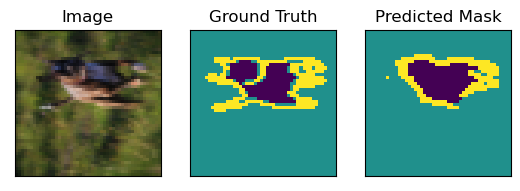

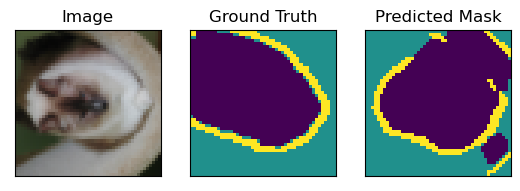

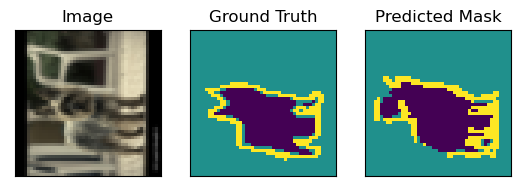

Epoch: 7


Test Loss: 0.23858728784151306, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


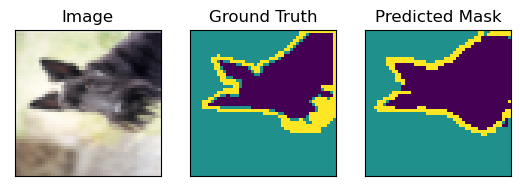

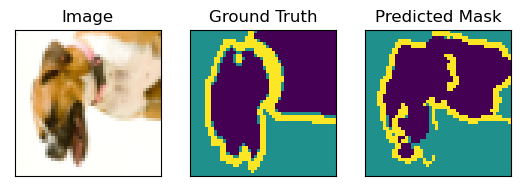

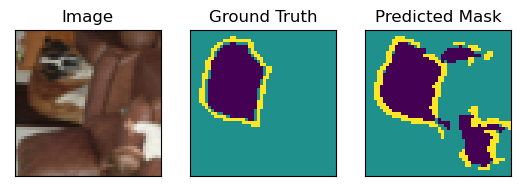

Epoch: 8


Test Loss: 0.24243889087305626, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:23<00:00,  4.88it/s]


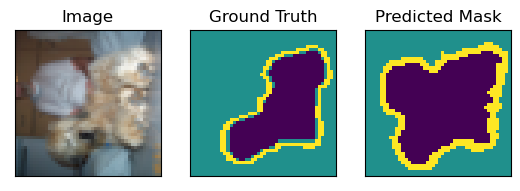

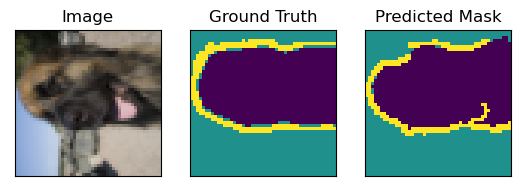

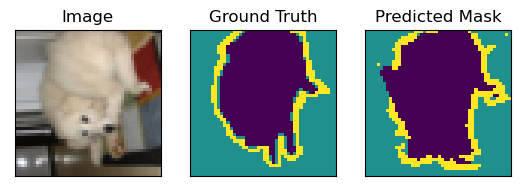

Epoch: 9


Test Loss: 0.2668846279911813, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


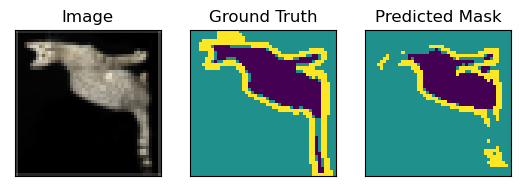

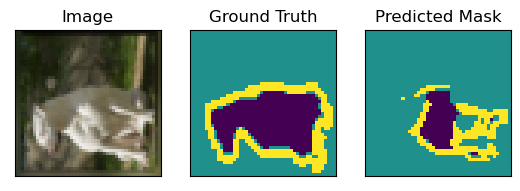

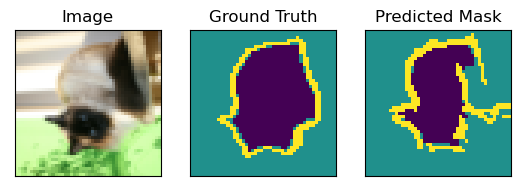

Epoch: 10


Test Loss: 0.2281889574093705, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.79it/s]


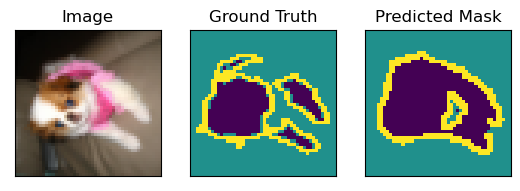

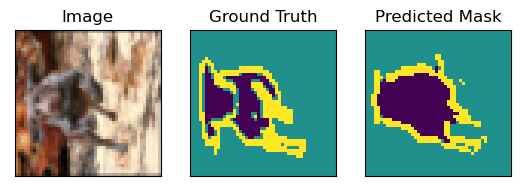

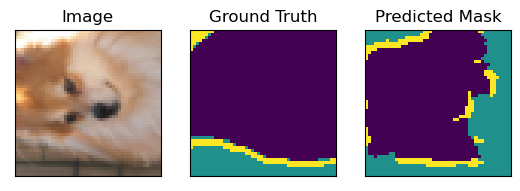

Epoch: 11


Test Loss: 0.2248870403915666, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.64it/s]


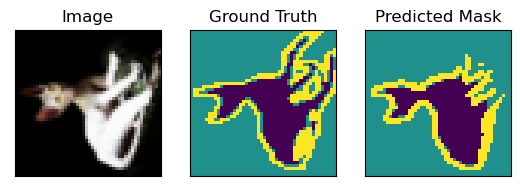

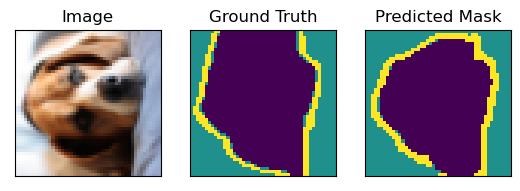

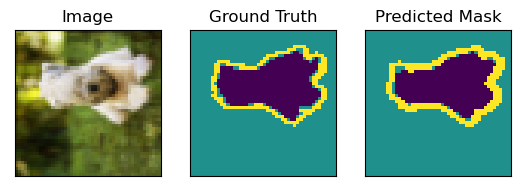

Epoch: 12


Test Loss: 0.20023666031251608, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:25<00:00,  4.56it/s]


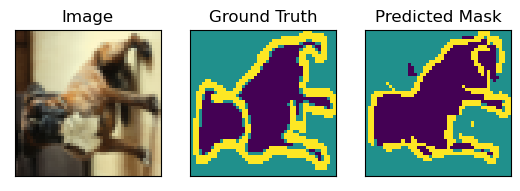

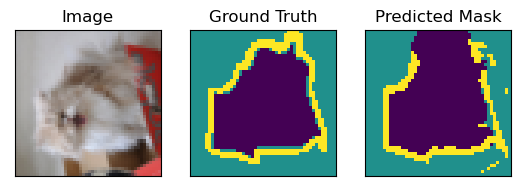

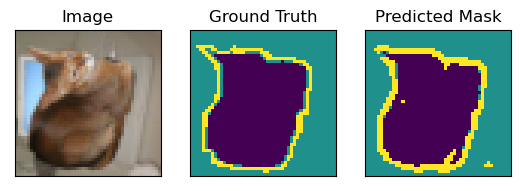

Epoch: 13


Test Loss: 0.2431080665869495, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:23<00:00,  4.81it/s]


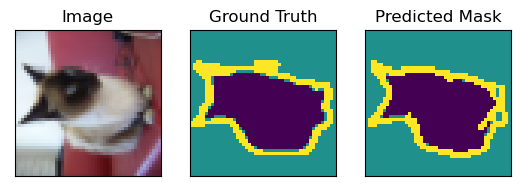

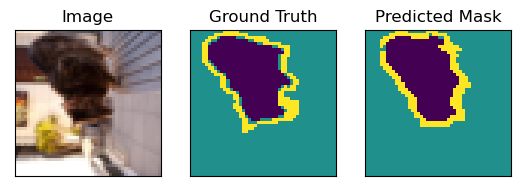

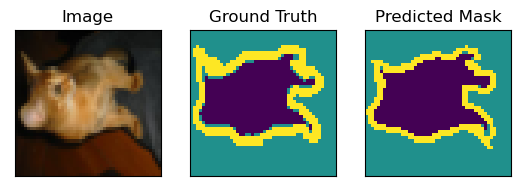

Epoch: 14


Test Loss: 0.21972110983699356, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.74it/s]


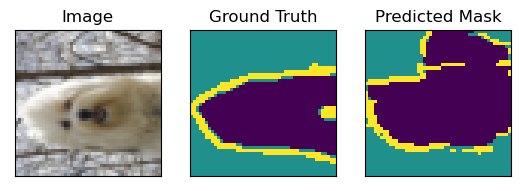

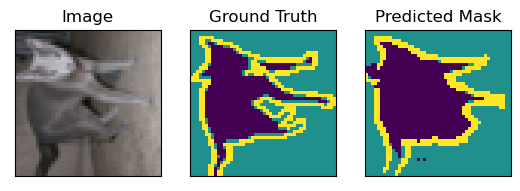

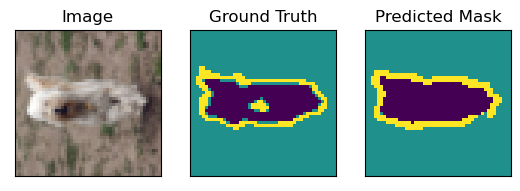

Epoch: 15


Test Loss: 0.24126297752376769, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.62it/s]


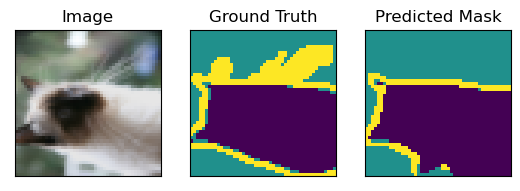

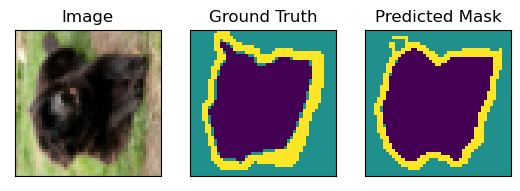

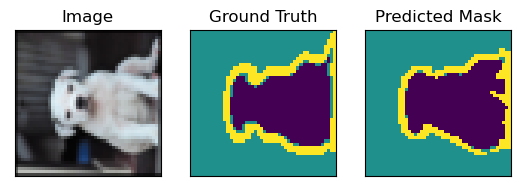

Epoch: 16


Test Loss: 0.27252799216160994, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.65it/s]


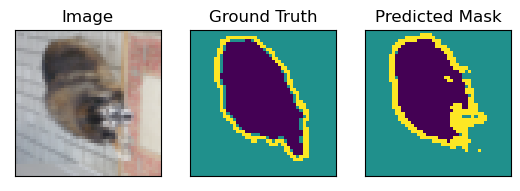

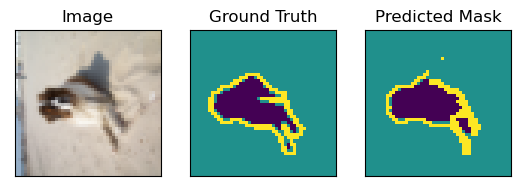

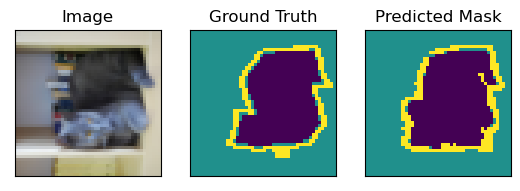

Epoch: 17


Test Loss: 0.21772366339364735, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.79it/s]


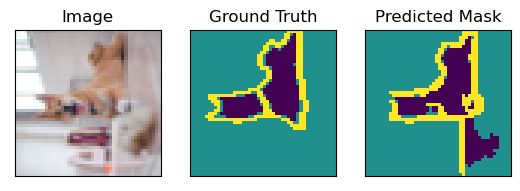

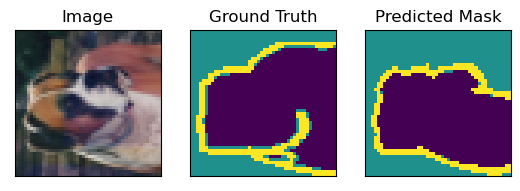

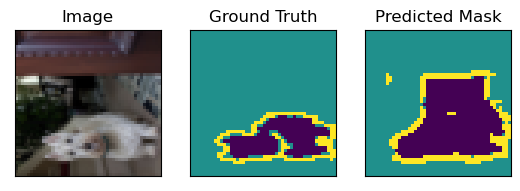

Epoch: 18


Test Loss: 0.1958563611354177, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.68it/s]


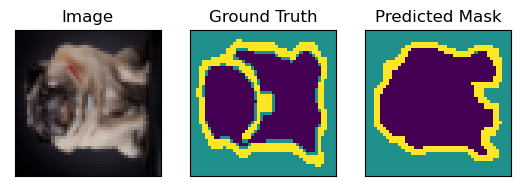

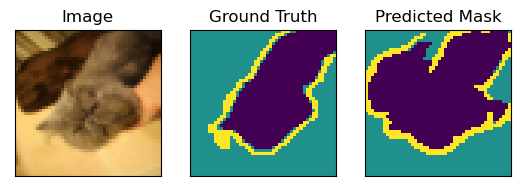

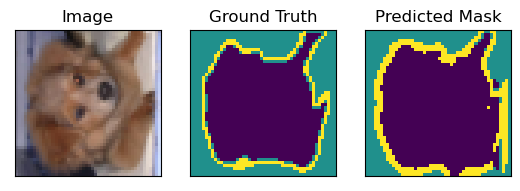

Epoch: 19


Test Loss: 0.2602131174503416, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.68it/s]


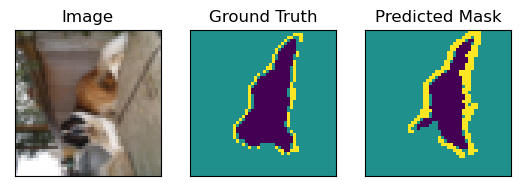

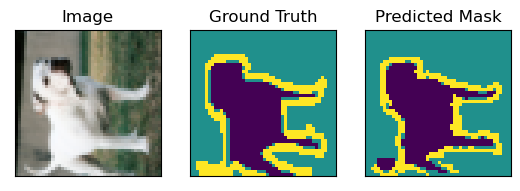

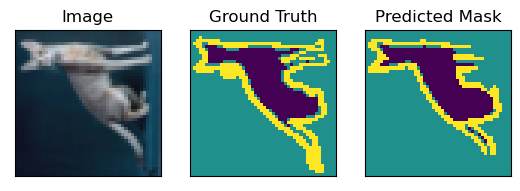

Epoch: 20


Test Loss: 0.187107021142078, batch_idx: 114: 100%|██████████████████████████████████| 115/115 [00:25<00:00,  4.53it/s]


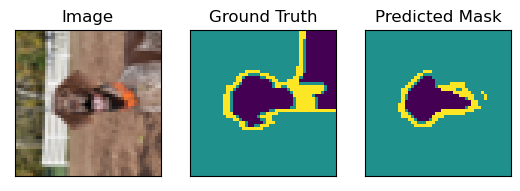

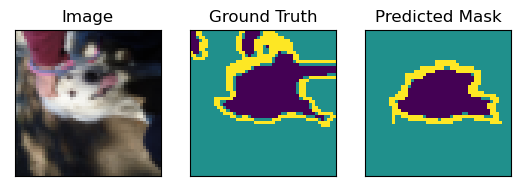

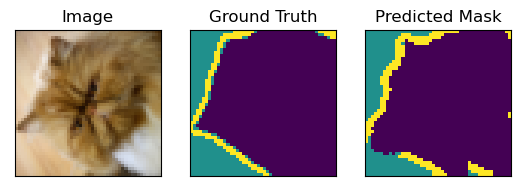

Epoch: 21


Test Loss: 0.22157434879835425, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.66it/s]


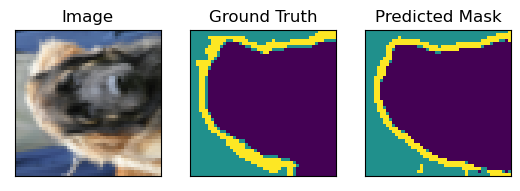

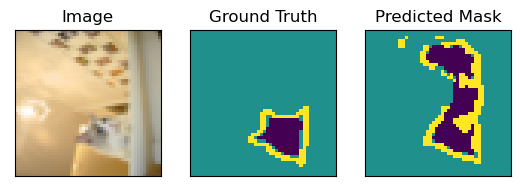

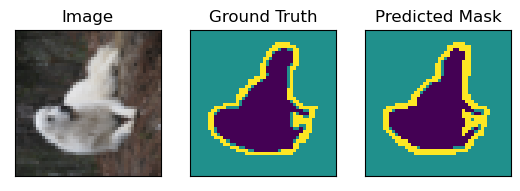

Epoch: 22


Test Loss: 0.20015341766569872, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.64it/s]


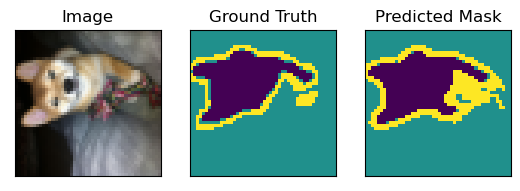

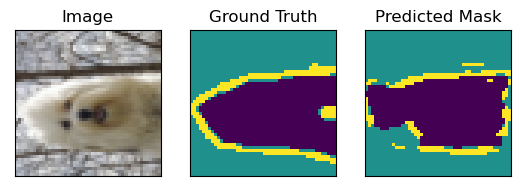

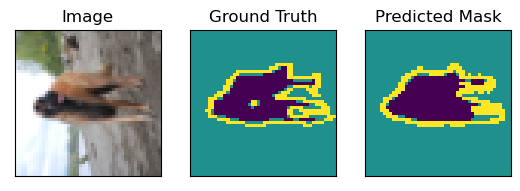

Epoch: 23


Test Loss: 0.20253405559352455, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:25<00:00,  4.54it/s]


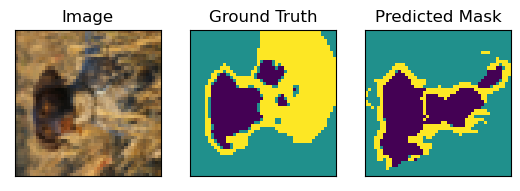

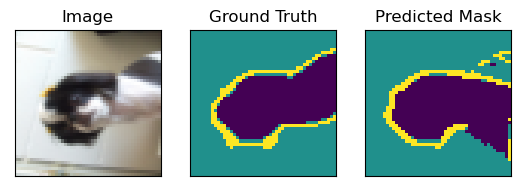

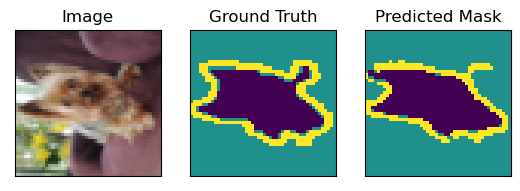

Epoch: 24


Test Loss: 0.2512090883264807, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:23<00:00,  4.90it/s]


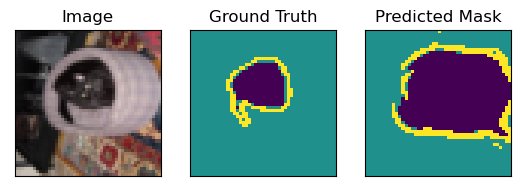

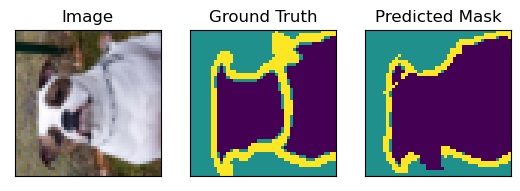

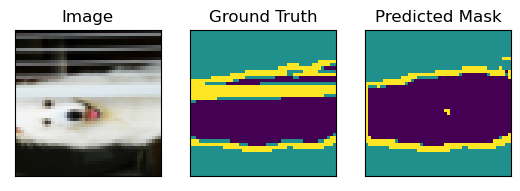

Epoch: 25


Test Loss: 0.20748528157396617, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.64it/s]


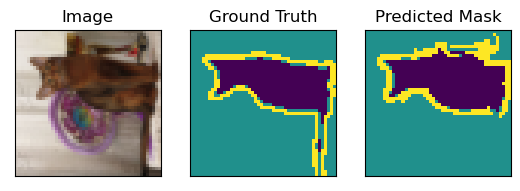

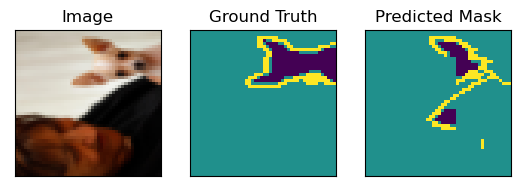

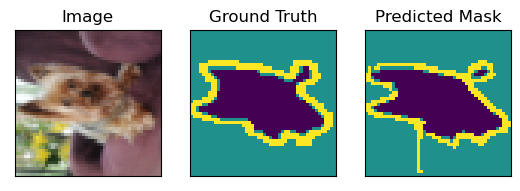

Epoch: 26


Test Loss: 0.23419919183135363, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.66it/s]


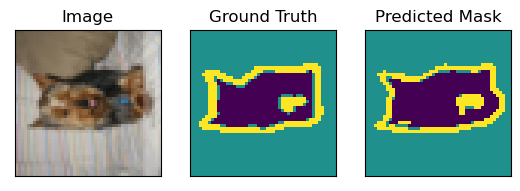

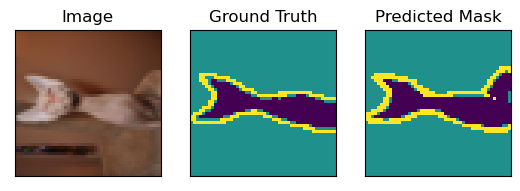

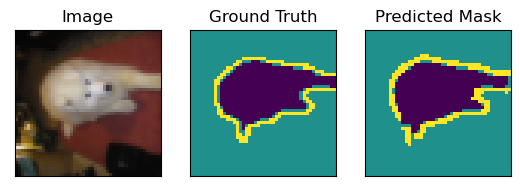

Epoch: 27


Test Loss: 0.18731274761995542, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.62it/s]


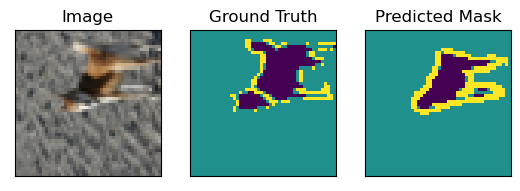

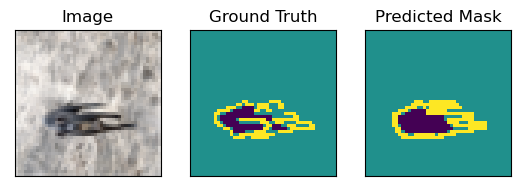

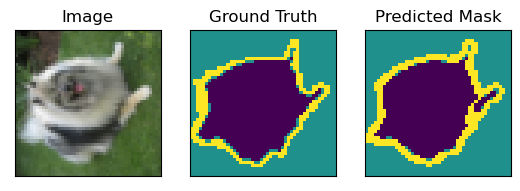

Epoch: 28


Test Loss: 0.19484478041346265, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.76it/s]


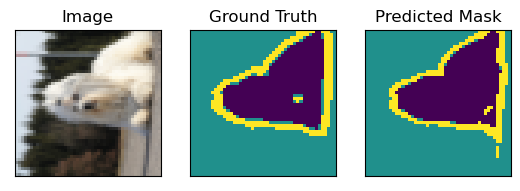

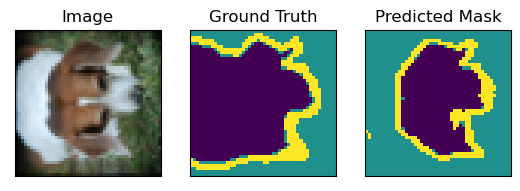

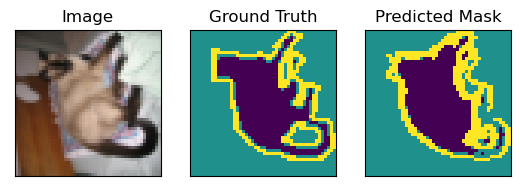

Epoch: 29


Test Loss: 0.26001908945157526, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.73it/s]


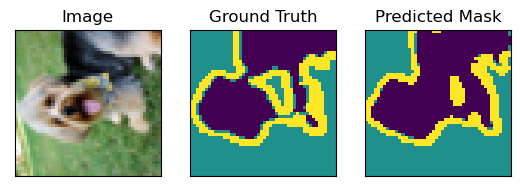

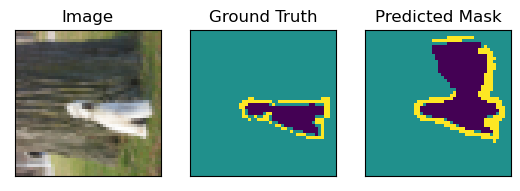

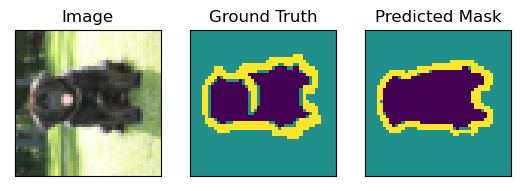

Epoch: 30


Test Loss: 0.23088151390663714, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.74it/s]


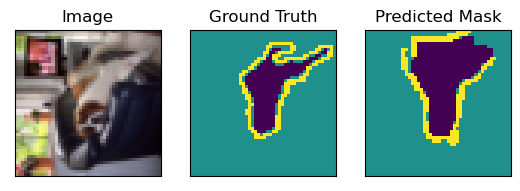

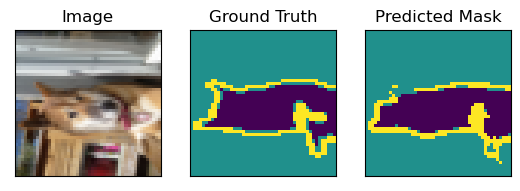

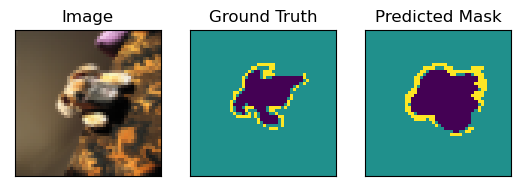

Epoch: 31


Test Loss: 0.21118814715602463, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.74it/s]


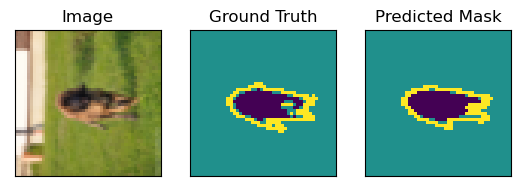

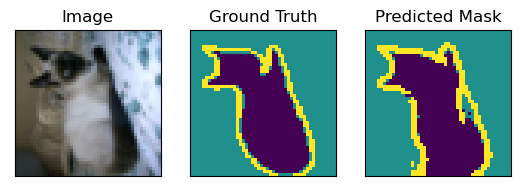

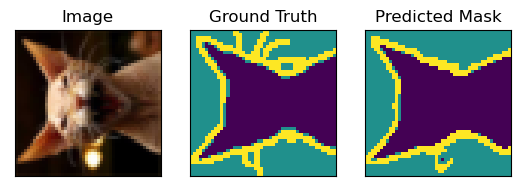

Epoch: 32


Test Loss: 0.21639406277982576, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.79it/s]


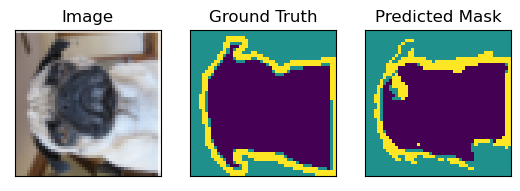

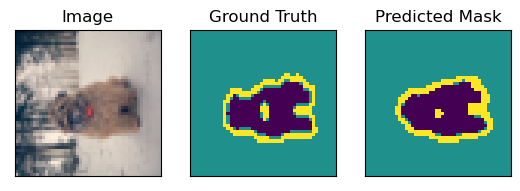

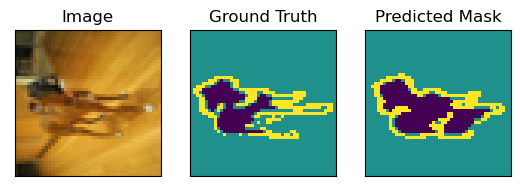

Epoch: 33


Test Loss: 0.17781225824713365, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.72it/s]


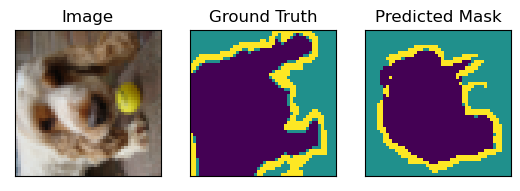

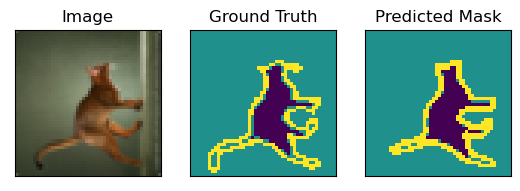

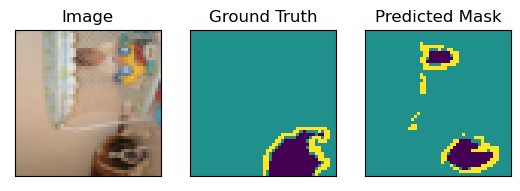

Epoch: 34


Test Loss: 0.2273731026148742, batch_idx: 114: 100%|█████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


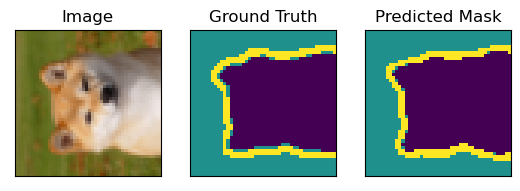

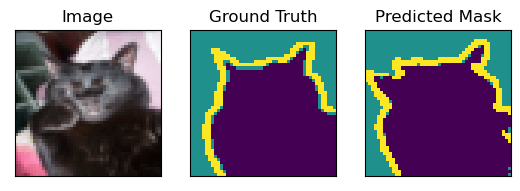

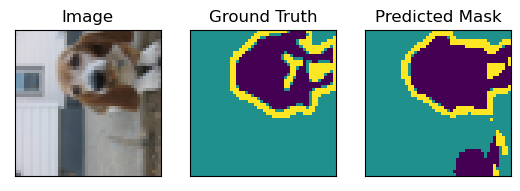

Epoch: 35


Test Loss: 0.22932528171521627, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:23<00:00,  4.79it/s]


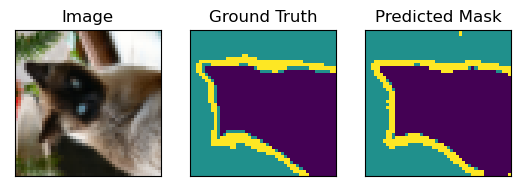

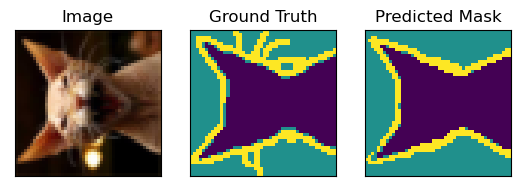

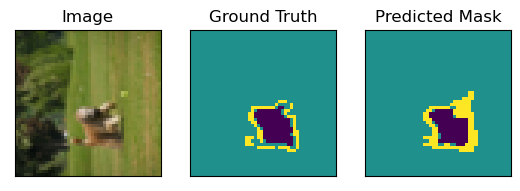

Epoch: 36


Test Loss: 0.24578439750882297, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.78it/s]


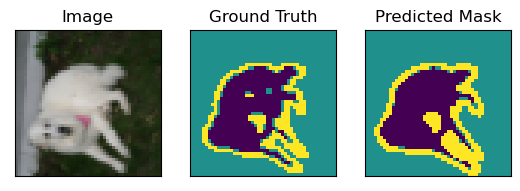

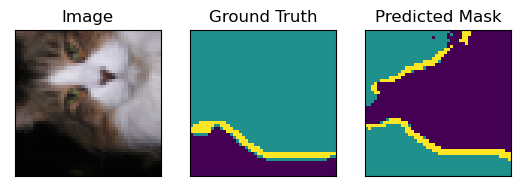

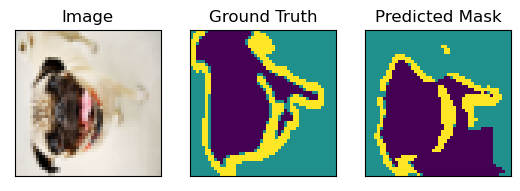

Epoch: 37


Test Loss: 0.19474606203660605, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.67it/s]


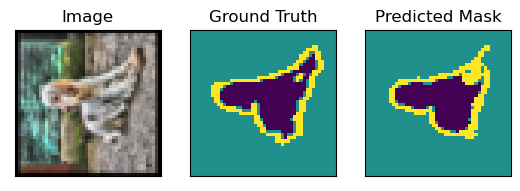

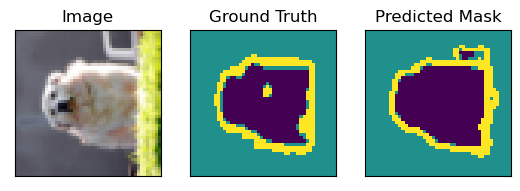

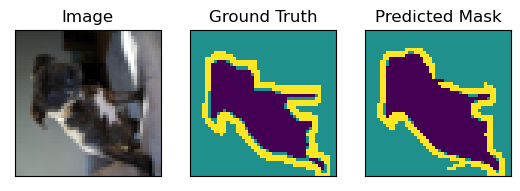

Epoch: 38


Test Loss: 0.18488883946055445, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.72it/s]


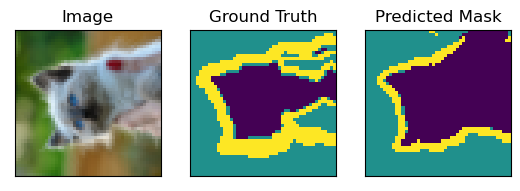

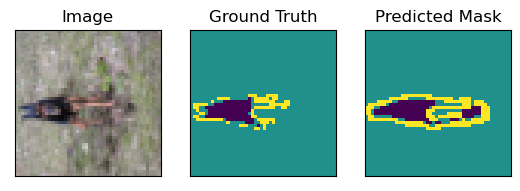

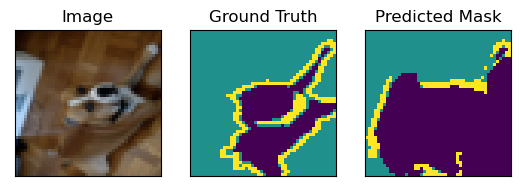

Epoch: 39


Test Loss: 0.19602666421592208, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.69it/s]


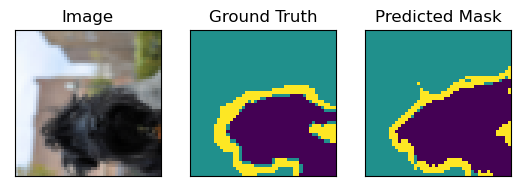

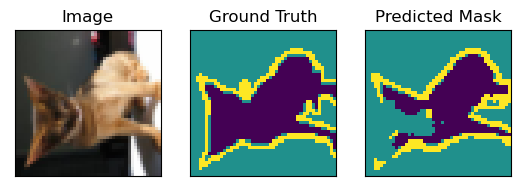

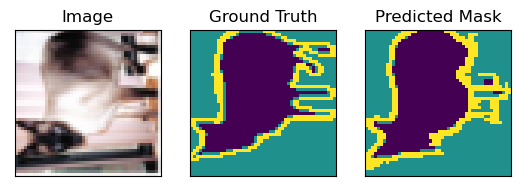

Epoch: 40


Test Loss: 0.22437814936239042, batch_idx: 114: 100%|████████████████████████████████| 115/115 [00:24<00:00,  4.71it/s]


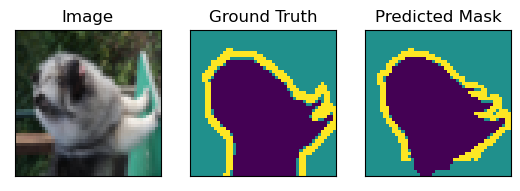

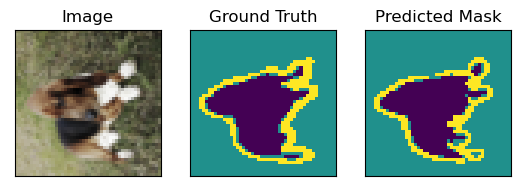

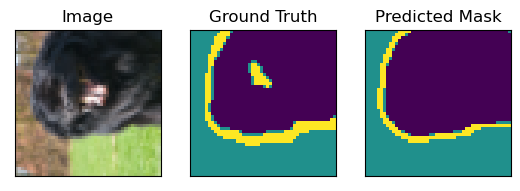

In [104]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    epoch_loss = model_train(unet_model, 
                            device, train_loader,
                            optimizer, criterion, train_acc, train_losses)
    epoch_test_loss = model_test(unet_model, 
                                device, test_loader, criterion, test_acc, test_losses)
    plot_sample(unet_model, device, test_loader, to_show=3)

In [107]:
train_losses_dice, test_losses_dice = train_losses[40:], test_losses[40:]

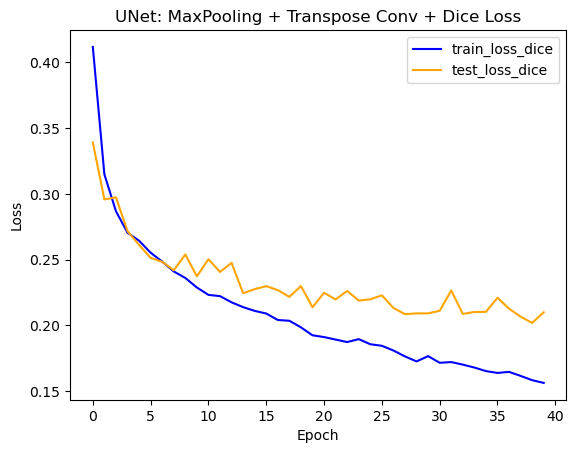

In [108]:
plt.plot(train_losses_dice, label= 'train_loss_dice', color='blue')
plt.plot(test_losses_dice, label='test_loss_dice', color='orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("UNet: MaxPooling + Transpose Conv + Dice Loss")
plt.show()